In [ ]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import imghdr
import tensorflow as tf
from PIL import Image
import seaborn as sns

from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.utils.class_weight import compute_class_weight

from tensorflow.keras import layers, models, regularizers, optimizers
from tensorflow.keras.applications import VGG16, ResNet50V2
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard, CSVLogger
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Dropout, Flatten, Dense, Activation, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.utils import plot_model

In [ ]:
from google.colab import files
upload = files.upload()

!pip install kaggle

!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d msambare/fer2013
import os
extract_dir = 'msambare/fer2013'
if not os.path.exists(extract_dir):
    os.makedirs(extract_dir)
else:
    # Clear the directory if it already exists
    for filename in os.listdir(extract_dir):
        file_path = os.path.join(extract_dir, filename)
        try:
            if os.path.isfile(file_path) or os.path.islink(file_path):
                os.unlink(file_path)
            elif os.path.isdir(file_path):
                os.rmdir(file_path)
        except Exception as e:
            print(f'Failed to delete {file_path}. Reason: {e}')

# Unzip the dataset
!unzip -q fer2013.zip -d msambare/fer2013

Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/msambare/fer2013
License(s): DbCL-1.0
 94% 57.0M/60.3M [00:02<00:00, 29.1MB/s]
100% 60.3M/60.3M [00:02<00:00, 23.6MB/s]


In [ ]:
# Define paths to the train and validation directories
train_data_dir = '/content/msambare/fer2013/train'
test_data_dir = '/content/msambare/fer2013/test'
# Set some parameters
img_width, img_height = 48, 48  # Size of images
batch_size = 64
epochs = 10
num_classes = 7  # Update this based on the number of your classes
# Rescale the pixel values (0-255) to the [0, 1] interval
data_generator = ImageDataGenerator(rescale=1./255,
                                    validation_split=0.2)

# Automatically retrieve images and their classes for train and validation sets
train_generator = data_generator.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale',
    subset='training')

validation_generator = data_generator.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale',
    subset='validation')

test_generator = data_generator.flow_from_directory(
    test_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale',)
    # subset='validation')

Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [ ]:
# Accessing class labels for the training data
train_class_labels = train_generator.class_indices
print("Training class labels:", train_class_labels)

# Accessing class labels for the validation data
validation_class_labels = validation_generator.class_indices
print("Validation class labels:", validation_class_labels)

# Accessing class labels for the validation data
test_class_labels = test_generator.class_indices
print("Validation class labels:", test_class_labels)

Training class labels: {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}
Validation class labels: {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}
Validation class labels: {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}


In [ ]:
# Initialising the CNN
model = Sequential()

# Adding convolutional layers with activations on the same line for clarity
model.add(Conv2D(32, kernel_size=(3, 3),kernel_initializer="glorot_uniform", padding='same', input_shape=(img_width, img_height, 1)))
model.add(Activation('relu'))
model.add(Conv2D(64, kernel_size=(3, 3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2, 2))
# model.add(Dropout(0.25))

model.add(Conv2D(128, kernel_size=(3, 3), padding='same', kernel_regularizer=regularizers.l2(0.01)))
model.add(Activation('relu'))
model.add(Conv2D(256, kernel_size=(3, 3), kernel_regularizer=regularizers.l2(0.01)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(512, kernel_size=(3, 3), padding='same', kernel_regularizer=regularizers.l2(0.01)))
model.add(Activation('relu'))
model.add(Conv2D(512, kernel_size=(3, 3), padding='same', kernel_regularizer=regularizers.l2(0.01)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.25))

# Flattening and adding dense layers
model.add(Flatten())
model.add(Dense(1024))
model.add(Activation('relu'))
model.add(Dropout(0.5))

# Output layer
model.add(Dense(num_classes))
model.add(Activation('softmax'))

In [ ]:
# Compiling the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
!mkdir -p /content/FER_2013_Emotion_Detection/Custom_CNN_From_Scratch

In [ ]:
# File path for the model checkpoint
cnn_path = '/content/FER_2013_Emotion_Detection/Custom_CNN_From_Scratch'
name = 'Custom_CNN_model.keras'
chk_path = os.path.join(cnn_path, name)
chk_path
# Callback to save the model checkpoint
checkpoint = ModelCheckpoint(filepath=chk_path,
                             save_best_only=True,
                             verbose=1,
                             mode='min',
                             monitor='val_loss')
# Callback for early stopping
earlystop = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=3,
                          verbose=1,
                          restore_best_weights=True)
# Callback to reduce learning rate
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=6,
                              verbose=1,
                              min_delta=0.0001)
# Callback to log training data to a CSV file
csv_logger = CSVLogger(os.path.join(cnn_path,'training.log'))
# Aggregating all callbacks into a list
callbacks = [checkpoint, earlystop, reduce_lr, csv_logger]  # Adjusted as per your use-case

In [ ]:
train_steps_per_epoch = train_generator.samples // train_generator.batch_size + 1
validation_steps_epoch = validation_generator.samples // validation_generator.batch_size + 1
test_steps_epoch = test_generator.samples // test_generator.batch_size + 1

In [ ]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_steps_per_epoch,
    epochs=15,
    validation_data=validation_generator,
    validation_steps=validation_steps_epoch,
    callbacks=callbacks)

Epoch 1/15
359/359 [==============================] - ETA: 0s - loss: 12.1417 - accuracy: 0.3119
Epoch 1: val_loss improved from inf to 13.88627, saving model to /content/FER_2013_Emotion_Detection/Custom_CNN_From_Scratch/Custom_CNN_model.keras
359/359 [==============================] - 46s 82ms/step - loss: 12.1417 - accuracy: 0.3119 - val_loss: 13.8863 - val_accuracy: 0.1730 - lr: 1.0000e-04
Epoch 2/15
359/359 [==============================] - ETA: 0s - loss: 9.5442 - accuracy: 0.3994
Epoch 2: val_loss improved from 13.88627 to 8.52511, saving model to /content/FER_2013_Emotion_Detection/Custom_CNN_From_Scratch/Custom_CNN_model.keras
359/359 [==============================] - 25s 69ms/step - loss: 9.5442 - accuracy: 0.3994 - val_loss: 8.5251 - val_accuracy: 0.4165 - lr: 1.0000e-04
Epoch 3/15
359/359 [==============================] - ETA: 0s - loss: 7.3687 - accuracy: 0.4415
Epoch 3: val_loss improved from 8.52511 to 6.51634, saving model to /content/FER_2013_Emotion_Detection/Custo

In [ ]:
cv2.VideoCapture(0)

< cv2.VideoCapture 0x7ce1d617cf30>

In [ ]:
def plot_training_history(history):
    """
    Plots the training and validation accuracy and loss.

    Parameters:
    - history: A Keras History object. Contains the logs from the training process.

    Returns:
    - None. Displays the matplotlib plots for training/validation accuracy and loss.
    """
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(len(acc))

    plt.figure(figsize=(20, 5))

    # Plot training and validation accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    # Plot training and validation loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')

    plt.show()

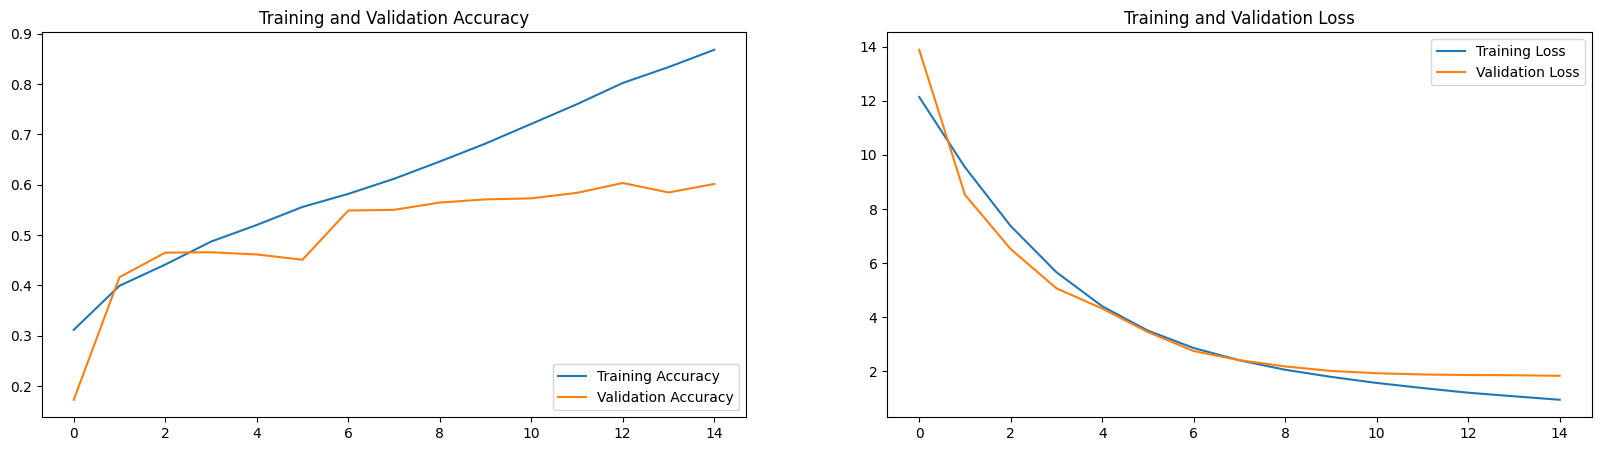

In [ ]:
plot_training_history(history)

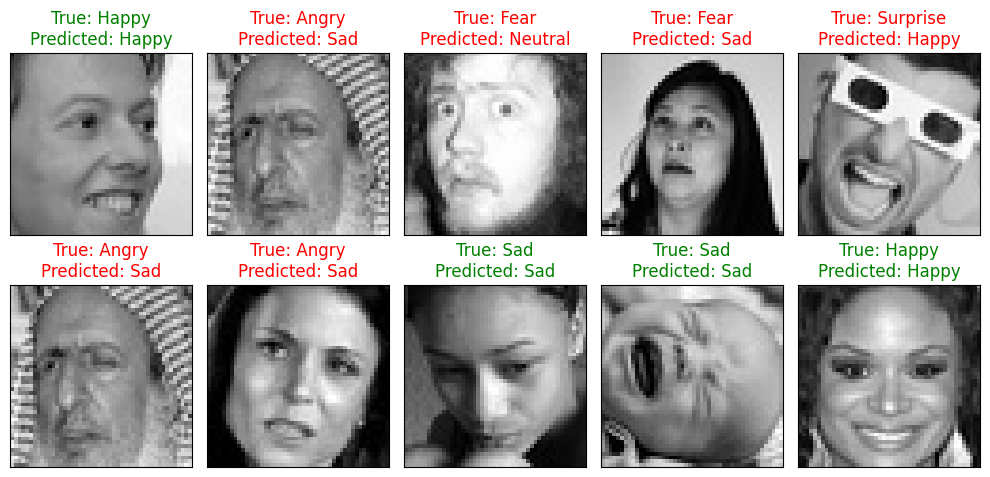

In [19]:
# Emotion classes for the dataset
Emotion_Classes = ['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']

# Assuming test_generator and model are already defined
batch_size = test_generator.batch_size

# Selecting a random batch from the test generator
Random_batch = np.random.randint(0, len(test_generator) - 1)

# Selecting random image indices from the batch
Random_Img_Index = np.random.randint(0, batch_size, 10)

# Setting up the plot
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(10, 5),
                         subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    # Fetching the random image and its label
    Random_Img = test_generator[Random_batch][0][Random_Img_Index[i]]
    Random_Img_Label = np.argmax(test_generator[Random_batch][1][Random_Img_Index[i]], axis=0)

    # Making a prediction using the model
    Model_Prediction = np.argmax(model.predict(tf.expand_dims(Random_Img, axis=0), verbose=0), axis=1)[0]

    # Displaying the image
    ax.imshow(Random_Img.squeeze(), cmap='gray')  # Assuming the images are grayscale
    # Setting the title with true and predicted labels, colored based on correctness
    color = "green" if Emotion_Classes[Random_Img_Label] == Emotion_Classes[Model_Prediction] else "red"
    ax.set_title(f"True: {Emotion_Classes[Random_Img_Label]}\nPredicted: {Emotion_Classes[Model_Prediction]}", color=color)

plt.tight_layout()
plt.show()

In [21]:
from tensorflow.keras.models import load_model

# Load the pre-trained model
model_path = '/content/FER_2013_Emotion_Detection/Custom_CNN_From_Scratch/Custom_CNN_model.keras'
model = load_model(model_path)

# Define the emotion labels (assuming the model predicts 7 emotions)
emotion_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

# Initialize the video capture object
cap = cv2.VideoCapture(0)

while True:
    ret, frame = cap.read()
    if not ret:
        break

    # Convert the frame to grayscale
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Resize the frame to the size expected by the model
    resized = cv2.resize(gray, (224, 224))  # Assuming the model expects 224x224 input
    normalized = resized / 255.0
    reshaped = np.reshape(normalized, (1, 224, 224, 1))

    # Predict the emotion
    prediction = model.predict(reshaped)
    emotion_index = np.argmax(prediction)
    emotion = emotion_labels[emotion_index]

    # Display the emotion on the frame
    cv2.putText(frame, emotion, (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)

    # Show the frame
    cv2.imshow('Emotion Detector', frame)

    # Break the loop if 'q' is pressed
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release the video capture object and close all OpenCV windows
cap.release()
cv2.destroyAllWindows()

this
